In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import kagglehub

Read and shuffle data

In [ ]:
path = kagglehub.dataset_download("gpiosenka/cats-in-the-wild-image-classification")
print(path)
data = pd.read_csv(os.path.join(path, 'WILDCATS.CSV'))
shuffled_data  = data.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_data.head()

/root/.cache/kagglehub/datasets/gpiosenka/cats-in-the-wild-image-classification/versions/1


,class id,filepaths,labels,data set,scientific name
0,1,train/CARACAL/210.jpg,CARACAL,train,Caracal caracal
1,1,train/CARACAL/197.jpg,CARACAL,train,Caracal caracal
2,2,train/CHEETAH/128.jpg,CHEETAH,train,Acinonyx jubatus
3,5,train/LIONS/191.jpg,LIONS,train,Panthera leo
4,2,train/CHEETAH/007.jpg,CHEETAH,train,Acinonyx jubatus


Load images

In [ ]:
from PIL import Image

image_size = (32, 32)
def load_image(image_path):
    full_path = os.path.join(path, image_path)
    with Image.open(full_path) as img:
        return np.array(img.resize(image_size))

images = shuffled_data['filepaths'].apply(load_image)

Changing the shape of the images

In [ ]:
print(type(images), images.shape, images.dtype)
import cv2
def convert_image_series_to_array(image_series, target_size=(32, 32)):
    # Initialize empty array with the desired shape
    n_samples = len(image_series)
    output_array = np.empty((n_samples, target_size[0], target_size[1], 3), dtype=np.uint8)

    # Convert each image in the series
    for idx, img in enumerate(image_series):
        # Ensure image is in correct format and size
        if isinstance(img, str):  # If image is a path
            img = cv2.imread(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif isinstance(img, np.ndarray) and img.shape != (*target_size, 3):
            img = cv2.resize(img, target_size)

        # Add the processed image to our output array
        output_array[idx] = img

    return output_array

images = convert_image_series_to_array(images)
print(type(images), images.shape, images.dtype)

<class 'pandas.core.series.Series'> (2439,) object
<class 'numpy.ndarray'> (2439, 32, 32, 3) uint8


Encode labels

In [ ]:
label_encoder = LabelEncoder()
shuffled_data['encoded_labels'] = label_encoder.fit_transform(shuffled_data['labels'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Labels map", label_mapping)

Labels map {'AFRICAN LEOPARD': 0, 'CARACAL': 1, 'CHEETAH': 2, 'CLOUDED LEOPARD': 3, 'JAGUAR': 4, 'LIONS': 5, 'OCELOT': 6, 'PUMA': 7, 'SNOW LEOPARD': 8, 'TIGER': 9}


In [ ]:
shuffled_data['encoded_labels_array'] = shuffled_data['encoded_labels'].apply(lambda x: np.array([x], dtype=np.uint8))
print(shuffled_data['encoded_labels_array'].head())

0    [1]
1    [1]
2    [2]
3    [5]
4    [2]
Name: encoded_labels_array, dtype: object


Split data and normalize

In [ ]:
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(shuffled_data['encoded_labels'], test_size=0.2, random_state=42)
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
y_train = y_train.to_numpy(dtype=np.uint8).reshape(-1, 1)
y_test = y_test.to_numpy(dtype=np.uint8).reshape(-1, 1)
print(type(x_train), x_train.shape, x_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)

<class 'numpy.ndarray'> (1951, 32, 32, 3) float64
<class 'numpy.ndarray'> (1951, 1) uint8


In [ ]:
print(type(x_test), x_test.shape, x_test.dtype)
print(type(y_test), y_test.shape, y_test.dtype)

<class 'numpy.ndarray'> (488, 32, 32, 3) float64
<class 'numpy.ndarray'> (488, 1) uint8


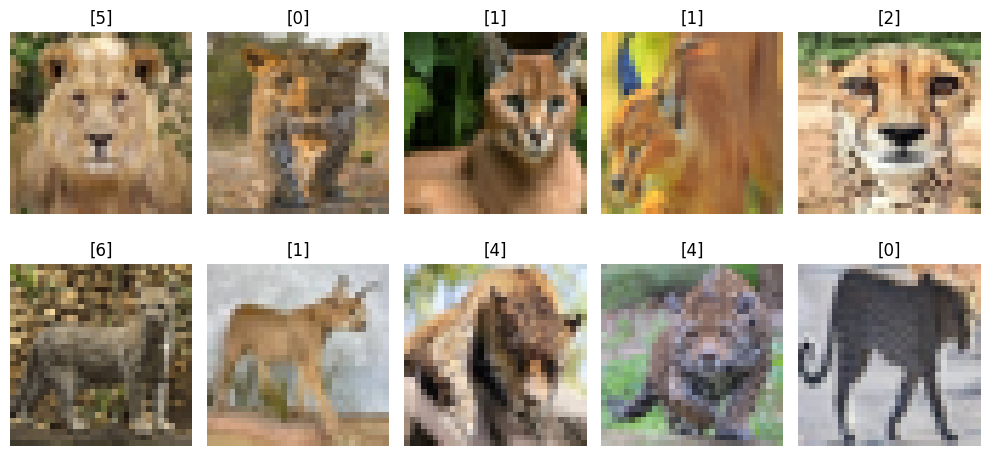

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(x_train[i])
  plt.title(y_train[i])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.backend import clear_session

clear_session()

model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01), input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,474,858 (5.63 MB)

 Trainable params: 1,472,426 (5.62 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)

print(y_train.shape)

(1951, 10)


In [ ]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=64)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 602ms/step - accuracy: 0.1407 - loss: 15.0562 - val_accuracy: 0.0742 - val_loss: 13.5456
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 591ms/step - accuracy: 0.2005 - loss: 13.9696 - val_accuracy: 0.0742 - val_loss: 12.9166
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.2206 - loss: 12.9958 - val_accuracy: 0.1202 - val_loss: 12.2248
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - accuracy: 0.2631 - loss: 11.9492 - val_accuracy: 0.1074 - val_loss: 11.4418
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - accuracy: 0.3041 - loss: 10.8202 - val_accuracy: 0.0997 - val_loss: 10.9765
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - accuracy: 0.3576 - loss: 9.9803 - val_accuracy: 0.1049 - val_loss: 10.3444
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 589ms/step - accuracy: 0.3417 - loss: 9.2171 - val_accuracy: 0.1407 - val_loss: 10.7116
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 580ms/step - accuracy: 0.4002 - los

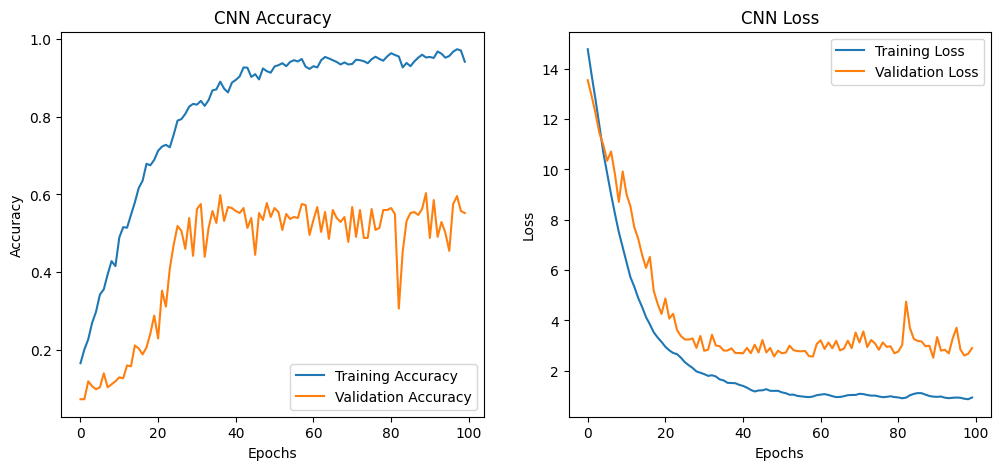

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1, 2 ,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label ='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Accuracy')
plt.subplot(1, 2 ,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss')
plt.show()

In [ ]:
#y_test = to_categorical(y_test, num_classes=10)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step


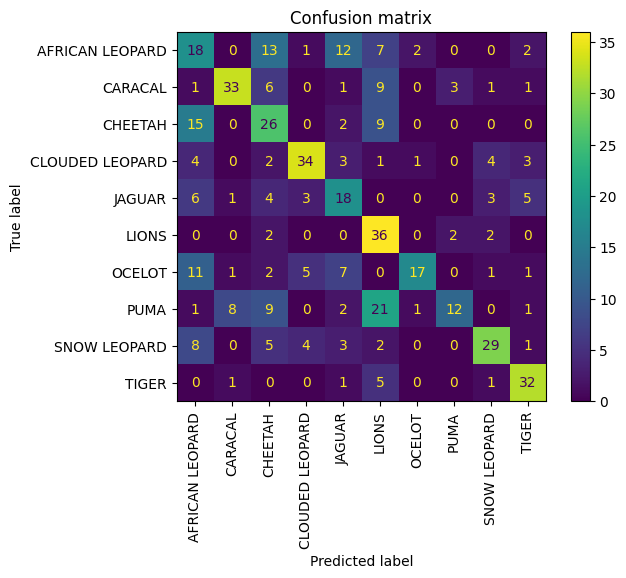

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping)
disp.plot(cmap='viridis', values_format='d', xticks_rotation='vertical')
plt.title('Confusion matrix')
plt.show()